# Contenido (hipervínculos)

1. <a href="L2D"> Modelo </a>

2. <a href="#caso1">Caso 1: Cilindro sumergido</a>

3. <a href="#caso2"> Caso 2: Isla cónica (NOAA)</a>

4. <a href="#caso3"> Caso 3: Chile 2010 (Moreno)</a>

# Load Test Data: Tsunami Chile 2010

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.io import loadmat


    361 ncols
    361 nrows
    -120.0 xll
    -60.0 yll
    0.166666666667 cellsize
    999999 nodata_value

* Download data from Clawpack site

In [2]:
from clawpack.geoclaw import topotools
import clawpack.clawutil.data as clawutildata
import clawpack.visclaw.colormaps as colormaps
topo_fname = 'etopo10min120W60W60S0S.asc'
url = 'http://www.geoclaw.org/topo/etopo/' + topo_fname
clawutildata.get_remote_file(url, output_dir='.', file_name=topo_fname,
        verbose=True)

data = np.loadtxt('etopo10min120W60W60S0S.asc',skiprows=6)
topo = np.reshape(data,(361,361))
lon = np.arange(-120.,-120+361*0.1666666667,0.1666666667)
lat = np.arange(-60.,-60+361*0.1666666667,0.1666666667)

topo2 = topotools.Topography(topo_fname, topo_type=2)

Skipping http://www.geoclaw.org/topo/etopo/etopo10min120W60W60S0S.asc 
  because file already exists: ./etopo10min120W60W60S0S.asc


* Create fancy earth colormap

In [14]:
region_extent = topo2.extent
mean_lat = 0.5 * (region_extent[3] + region_extent[2])

topo_extent = (np.min(topo2.Z), np.max(topo2.Z))

# Create color map - assume shore is at z = 0.0
land_cmap = colormaps.make_colormap({ 0.0:[0.1,0.4,0.0],
                                     0.25:[0.0,1.0,0.0],
                                      0.5:[0.8,1.0,0.5],
                                      1.0:[0.8,0.5,0.2]})
sea_cmap = plt.get_cmap('Blues_r')
cmap, norm = colormaps.add_colormaps((land_cmap, sea_cmap), 
                                         data_limits=topo_extent,
                                         data_break=0.0)

* Plot current data

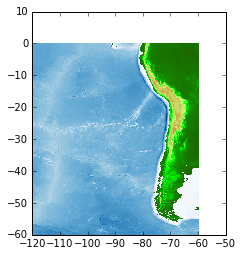

In [13]:
f = plt.figure()
ax = f.add_subplot(111)
ax.set_aspect(1.0 / np.cos(np.pi / 180.0 * mean_lat))
plt.pcolormesh(topo2.X, topo2.Y, topo2.Z, norm=norm,cmap=cmap)
# plt.axis('equal')

# Set the simulation

Boundaries are the same as in the normal case

Parámetros

In [67]:
R_earth = 6378000.
rad_deg = 0.01745329252
rad_min = 0.000290888208665721
cori_w = 7.2722e-5
g = 9.81

* Set grid properties. Notice that $dx$ and $dy$ are **INPUT** and are in **MINUTES**

In [68]:
x = topo2.x
y = topo2.y
xmesh, ymesh = np.meshgrid(x,y,indexing='ij')

nx = x.shape[0]
ny = y.shape[0]
dx = np.diff(x)[0] #in minutes
dy = np.diff(y)[0] #in minutes
dt = 0.45*min(dx,dy)/np.sqrt(g*np.max(-topo2.Z))

In [69]:
h = -topo2.Z
RR = dt/R_earth
cosM = np.cos(ymesh*rad_deg) 
R1 = RR/(cosM*dx*rad_min)
R11 = RR/(cosM*dy*rad_min)
R6 = np.cos(y+0.5*dy/60.0)

In [71]:
RS = g*RR
hp = h*1.0
hp[0:-1,:] = 0.5*(h[0:-1,:]+h[1:,:])
R2 = np.where(hp>0,RS/(cosM*dx*rad_min),0.0)
RT = 0.5*dt*cori_w

In [72]:
hq = h*1.0
hq[:,0:-1] = 0.5*(h[:,0:-1]+h[:,1:])
R4 = np.where(hq>0,RS/(dy*rad_min),0.0)

* The variables that **matter**: $\eta,p,q$

In [62]:
nt = 2
eta = np.zeros((nt,nx,ny))
p = np.zeros_like(eta)
q = np.zeros_like(eta)

In [63]:
# def simulation(x,h,eta,p,q,rx,ry,dx,dy,cfl,nt,gx):

zdepth = np.zeros_like(eta)
zdepth[0,:,:] = eta[0,:,:]+h
for n in range(nt-1):
    ## Mas Loop
    for i in range(1, nx-1):
        for j in range(1, ny-1):
            if (h[i,j]>0.0):
                zzz = eta[n,i,j] - R1[i,j]*(p[n,i,j]-p[n,i-1,j]) \
                               - R11[i,j]*(q[n,i,j]*R6[j]-q[n,i,j-1]*R6[j-1])
                DD = zzz + h[i,j]
                zdepth[n+1,i,j] = DD
                eta[n+1,i,j] = zzz    
            else:
                eta[n+1,i,j] = 0.0
    
    # momentum in x-direction
    for i in range(0,nx-1):
        for j in range(0,ny-1):
            ip1 = min(nx-1,i+1)
            im1 = max(0,i-1)
            jp1 = min(ny-1,j+1)
            jm1 = max(0,j-1)
            
            if h[i,j]>gx and h[ip1,j]>gx:
                tot_n = q[n,i,j]+q[n,ip1,j]+q[n,i,jm1]+q[ip1,jm1]
                xm = p[n,i,j] - R2[i,j]*()
                hM = 0.5*(h[i,j]+h[ip1,j]) + 0.5 *(eta[n+1,i,j]+eta[n+1,ip1,j])
                p[n+1,i,j]  = p[n,i,j] - 9.81 * rx*hM * (eta[n+1,ip1,j]-eta[n+1,i,j])
            else:
                p[n+1,i,j] = 0.0

    # momentum in y-direction
    for i in range(0,nx-1):
        for j in range(0,ny-1):
            ip1 = min(nx-1,i+1)
            jp1 = min(ny-1,j+1)

            if h[i,j]>gx and h[i,jp1]>gx:
                hN = 0.5*(h[i,j]+h[i,jp1]) + 0.5 *(eta[n+1,i,j]+eta[n+1,i,jp1])
                q[n+1,i,j]  = q[n,i,j] - 9.81 *ry* hN * (eta[n+1,i,jp1]-eta[n+1,i,j])
            else:
                q[n+1,i,j] = 0.0  
    


In [ ]:
def simulation(x,h,eta,p,q,rx,ry,dx,dy,cfl,nt,gx):
    dp1 = np.zeros_like(x)
    dp2 = np.zeros_like(x)
    dq1 = np.zeros_like(x)
    dq2 = np.zeros_like(x)

    zdepth = np.zeros_like(eta)
    zdepth[0,:,:] = eta[0,:,:]+h

    t0 = time.clock()
    for n in range(nt-1):


        ## Mas Loop
        for i in range(1, nx-1):
            for j in range(1, ny-1):
                if (h[i,j]>gx):
                    zzz = eta[n,i,j] - rx*(p[n,i,j]-p[n,i-1,j]) \
                                   - ry*(q[n,i,j]-q[n,i,j-1])
                    DD = zzz + h[i,j]
                    zdepth[n+1,i,j] = DD
                    eta[n+1,i,j] = zzz    
                else:
                    eta[n+1,i,j] = 0.0
        # open boundary
        
        j = 0
        for i in range(1,nx-1):
            if h[i,j]>gx:
                cc = np.sqrt(9.81*h[i,j])
                uh = 0.5*(p[n,i,j]+p[n,i-1,j])
                uu = np.sqrt(uh**2+q[n,i,j]**2)
                zz = uu/cc
                if q[n,i,j]>0:
                    zz = -zz
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]
            else:
                zz = 0.0
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]                        

        j = ny-1
        for i in range(1,nx-1):
            if h[i,j]>gx:
                cc = np.sqrt(9.81*h[i,j])
                uh = 0.5*(p[n,i,j]+p[n,i-1,j])
                uu = np.sqrt(uh**2+q[n,i,j-1]**2)
                zz = uu/cc
                if q[n,i,j-1]<0:
                    zz = -zz
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]
            else:
                zz = 0.0
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]                

        i = 0
        for j in range(1,ny-1):
            if h[i,j]>gx:
                cc = np.sqrt(9.81*h[i,j])
                if h[i,j-1]>gx:
                    uh = 0.5*(q[n,i,j]+q[n,i,j-1])
                else:
                    uh = q[n,i,j]
                uu = np.sqrt(uh**2+p[n,i,j]**2)
                zz = uu/cc
                if p[n,i,j]>0:
                    zz = -zz
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]
            else:
                zz = 0.0
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]

        i = nx-1
        for j in range(1,ny-1):
            if h[i,j]>gx:
                cc = np.sqrt(9.81*h[i,j])
                uh = 0.5*(q[n,i,j]+q[n,i,j-1])
                uu = np.sqrt(uh**2+p[n,i-1,j]**2)
                zz = uu/cc
                if p[n,i-1,j]<0:
                    zz = -zz
                eta[n+1,i,j] = zz     
                zdepth[n+1,i,j] = zz+h[i,j]
            else:
                zz = 0.0
                eta[n+1,i,j] = zz
                zdepth[n+1,i,j] = zz+h[i,j]


        i = 0
        j = 0
        if h[i,j]>gx:
            cc = np.sqrt(9.81*h[i,j])
            qx = p[n,i,j]
            qy = q[n,i,j]
            uu = np.sqrt(qx**2+qy**2)        
            zz = uu/cc
            if qx>0 or qy>0:
                zz = -zz
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]
        else:
            zz = 0.0
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]           

        i = nx-1
        j = 0
        if h[i,j]>gx:
            cc = np.sqrt(9.81*h[i,j])
            qx = p[n,i-1,j]
            qy = q[n,i,j]
            uu = np.sqrt(qx**2+qy**2)        
            zz = uu/cc
            if qx<0 or qy>0:
                zz = -zz
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]
        else:
            zz = 0.0
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]                 

        i = 0
        j = ny-1
        if h[i,j]>gx:
            cc = np.sqrt(9.81*h[i,j])
            qx = p[n,i,j]
            qy = q[n,i,j-1]
            uu = np.sqrt(qx**2+qy**2)        
            zz = uu/cc
            if qx>0 or qy<0:
                zz = -zz
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]
        else:
            zz = 0.0
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]

        i = nx-1
        j = ny-1
        if h[i,j]>gx:
            cc = np.sqrt(9.81*h[i,j])
            qx = p[n,i-1,j]
            qy = q[n,i,j-1]
            uu = np.sqrt(qx**2+qy**2)        
            zz = uu/cc
            if qx<0 or qy<0:
                zz = -zz
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]
        else:
            zz = 0.0
            eta[n+1,i,j] = zz
            zdepth[n+1,i,j] = zz+h[i,j]                  
           

        # momentum loop

        # momentum in x-direction
        for i in range(0,nx-1):
            for j in range(0,ny-1):
                ip1 = min(nx-1,i+1)
                jp1 = max(0,i-1)
                
                if h[i,j]>gx and h[ip1,j]>gx:
                    hM = 0.5*(h[i,j]+h[ip1,j]) + 0.5 *(eta[n+1,i,j]+eta[n+1,ip1,j])
                    p[n+1,i,j]  = p[n,i,j] - 9.81 * rx*hM * (eta[n+1,ip1,j]-eta[n+1,i,j])
                else:
                    p[n+1,i,j] = 0.0

        # momentum in y-direction
        for i in range(0,nx-1):
            for j in range(0,ny-1):
                ip1 = min(nx-1,i+1)
                jp1 = min(ny-1,j+1)
                
                if h[i,j]>gx and h[i,jp1]>gx:
                    hN = 0.5*(h[i,j]+h[i,jp1]) + 0.5 *(eta[n+1,i,j]+eta[n+1,i,jp1])
                    q[n+1,i,j]  = q[n,i,j] - 9.81 *ry* hN * (eta[n+1,i,jp1]-eta[n+1,i,j])
                else:
                    q[n+1,i,j] = 0.0  
    
        t1 = time.clock()    
        print '%.3f'%(n*1.0/nt), 'elapsed: %.3f s, estimated %.3f s:'%(t1-t0,(t1-t0)*nt*1.0/(n+1))
    return eta,p,q